# Emission x cost analysis

- Estimates through new exp/sin model

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from scipy.interpolate import UnivariateSpline, PchipInterpolator
from scipy.optimize import minimize_scalar

In [ ]:
def find_minima_1d(emission, cost, nx=500, smooth_factor=None, use_pchip=False):
    """
    emission: array-like (x)
    cost: array-like (y)
    nx: número de pontos para amostragem fina (se usar PCHIP)
    smooth_factor: s do UnivariateSpline (quanto maior, mais suave). Se None, o SciPy escolhe.
    use_pchip: se True, usa PCHIP (monótono, sem overshoot), senão usa spline suave.
    """

    # 1) Ordenar por emissão e remover duplicatas
    x, idx = np.unique(np.asarray(emission, float), return_index=True)
    y = np.asarray(cost, float)[idx]

    # 2) Construir substituto

    if use_pchip:

        # PCHIP não dá derivada analítica fácil para raízes,
        # mas podemos amostrar finamente para achar mínimos discretos.
        f = PchipInterpolator(x, y)

        # malha fina
        xf = np.linspace(x.min(), x.max(), 2001)
        yf = f(xf)

        # mínimos locais discretos: ponto menor que vizinhos
        loc_idxs = np.where((yf[1:-1] < yf[:-2]) & (yf[1:-1] < yf[2:]))[0] + 1
        local_minima = [(xf[i], yf[i]) for i in loc_idxs]

        # global
        cand = local_minima + [(x[0], f(x[0])), (x[-1], f(x[-1]))]
        xg, yg = min(cand, key=lambda t: t[1])

        return {"local_minima": local_minima, "global_min": (xg, yg), "func_model": f}

    else:

        # Spline cúbico suavizado com derivadas
        spl = UnivariateSpline(x, y, s=smooth_factor)

        # 3) Raízes da derivada (candidatos a extremos)
        d1 = spl.derivative(1)
        d2 = spl.derivative(2)
        crit = d1.roots()  # pontos onde f'(x)=0

        # filtrar para mínimo local: f''(x) > 0 e dentro do domínio
        local_minima = []
        for xc in crit:
            if x.min() <= xc <= x.max():
                if d2(xc) > 0:
                    local_minima.append((xc, spl(xc)))

        # 4) mínimo global: checar também as bordas
        cand = local_minima + [(x[0], spl(x[0])), (x[-1], spl(x[-1]))]
        xg, yg = min(cand, key=lambda t: t[1])

        # (opcional) confirmar global com minimize_scalar no spline
        res = minimize_scalar(
            lambda z: float(spl(z)), bounds=(x.min(), x.max()), method="bounded"
        )
        if res.success and res.fun < yg:
            xg, yg = res.x, res.fun

        return {"local_minima": local_minima, "global_min": (xg, yg), "func_model": spl}

In [ ]:
df = pd.read_csv("ccu_emission_cost_time_series.csv")

company = ["S1", "C2", "S2", "P1", "C1", "A1"]
scenario = ["GBM", "DBM"]

for s in scenario:
    df_ = df[df["Scenario"] == s]

    opt_results[s] = {}

    for c in company:
        print(f"Processing {c}/{s}...")
        emission = df_[f"Emission_{c}"].values / 1e6
        cost = df_[f"Cost_{c}"].values

        opt_results[s][c] = find_minima_1d(
            emission, cost, smooth_factor=None, use_pchip=True
        )  # ajuste s conforme ruído

        opt_results[s][c]["emission"] = emission
        opt_results[s][c]["cost"] = cost

Processing S1/GBM...
Processing C2/GBM...
Processing S2/GBM...
Processing P1/GBM...
Processing C1/GBM...
Processing A1/GBM...
Processing S1/DBM...
Processing C2/DBM...
Processing S2/DBM...
Processing P1/DBM...
Processing C1/DBM...
Processing A1/DBM...


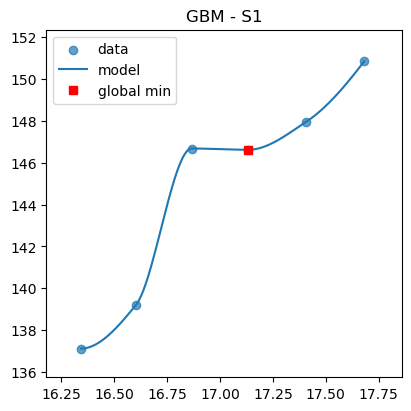

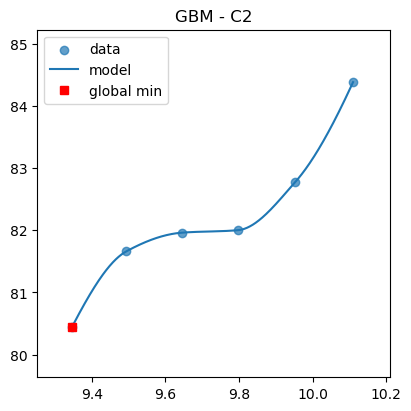

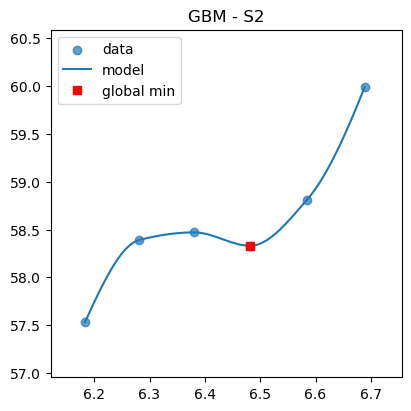

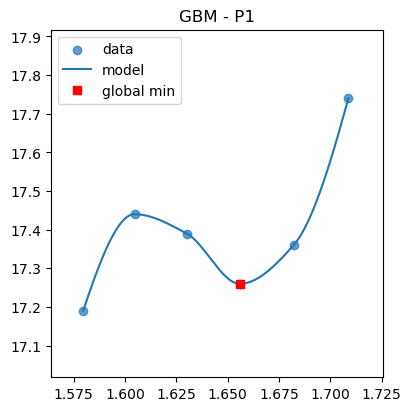

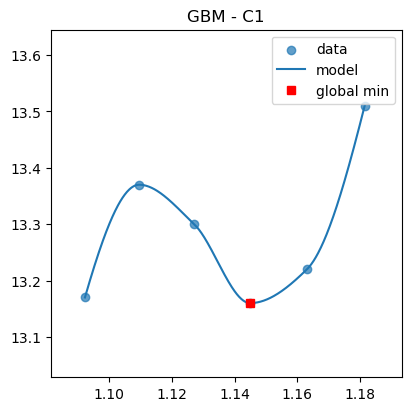

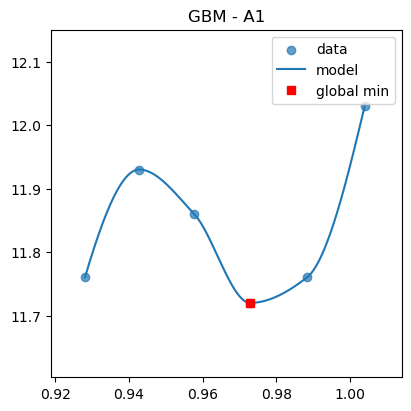

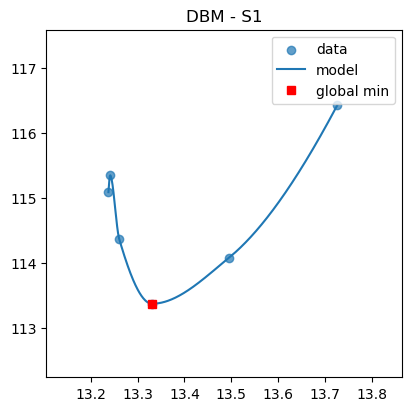

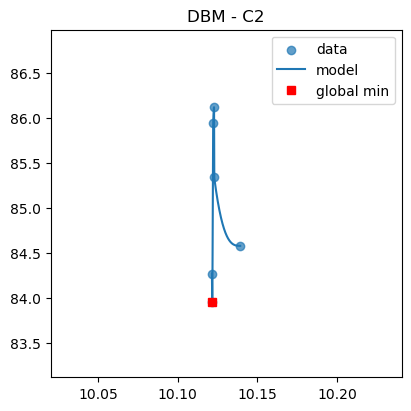

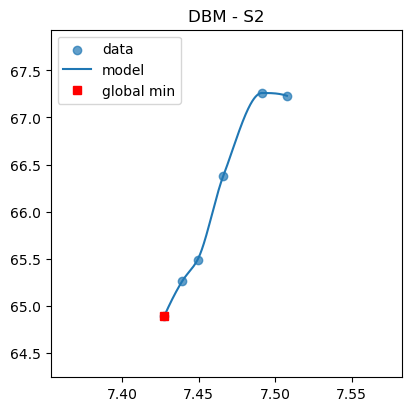

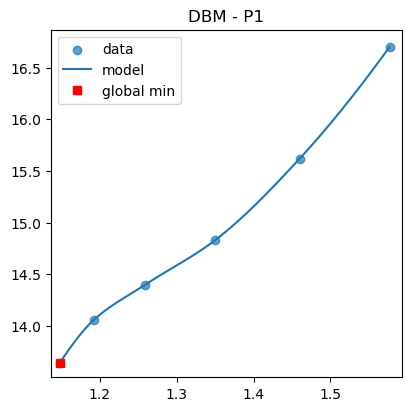

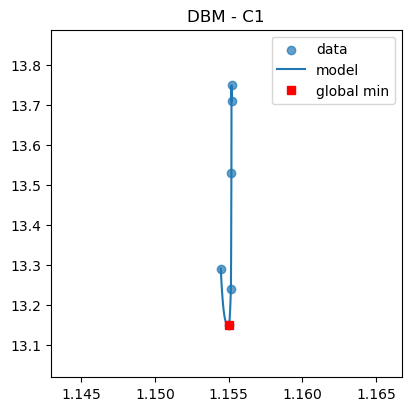

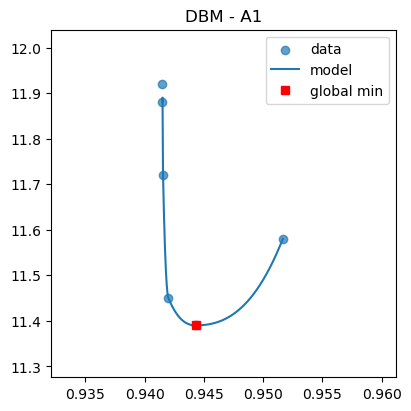

In [ ]:
def plot_global_minima(s, c, results, save=False, outdir="figs"):
    """
    Plota dados, modelo ajustado e mínimo global para (s, c).

    s: cenário (str)
    c: empresa (str)
    results: dicionário com resultados (ex: opt_results)
    save: se True, salva a figura em arquivo
    outdir: diretório de saída para salvar
    """
    f = results[s][c]["func_model"]

    lm, gm = (
        len(results[s][c]["local_minima"]) > 0,
        len(results[s][c]["local_minima"]) > 0,
    )

    if lm or gm:
        e_opt, c_opt = results[s][c]["local_minima"][0]
    else:
        e_opt, c_opt = results[s][c]["global_min"]

    emission = results[s][c]["emission"]
    cost = results[s][c]["cost"]
    e = np.linspace(emission.min(), emission.max(), 500)

    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.scatter(emission, cost, label="data", alpha=0.7)
    ax.plot(e, f(e), label="model", color="tab:blue")
    ax.plot(e_opt, c_opt, "s", color="red", markersize=6, label="global min")

    pad_x, pad_y = 0.01, 0.01
    ax.set_xlim((1 - pad_x) * emission.min(), (1 + pad_x) * emission.max())
    ax.set_ylim((1 - pad_y) * cost.min(), (1 + pad_y) * cost.max())
    ax.set_title(f"{s} - {c}")
    ax.legend()

    if save:
        import os

        os.makedirs(outdir, exist_ok=True)
        fname = f"{outdir}/{s}_{c}.png"
        fig.savefig(fname, dpi=150)
        plt.close(fig)  # fecha se não quiser abrir todas na tela
    else:
        plt.show()


for s in scenario:
    for c in company:
        plot_global_minima(s, c, opt_results, save=False)